In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from pathlib import Path
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2
from keras.models import model_from_json
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

Using TensorFlow backend.


### Aim
The primary aim of this project is to experiment with hyper-parameters of different Convoluted Neural Network structures 
to see how they affect classification performance on the dataset. The focus is on thoroughness rather than computational 
efficiency. This is also why I haven't decided to implement transfer learning even though it may have improved 
performance and training time.

### The Chest X-ray Dataset
The dataset was acquired from Kaggle and consists of 5863 images (JPEG). It is split into 3 subfolders for training,
 testing and validation. Within each subfolder The images are either classed as 'NORMAL' or 
'PNEUMONIA' in their own respective folders. While all the images were correctly classed, the dataset isn't perfectly clean 
so more extreme classification rates mights be harder to achieve. 
  
The pictures below are two sample images from the dataset. I used the OpenCV library in conjunction with pyplot because 
they allowed BGR to RGB conversion which is necessary when displaying jpeg files with pyplot.

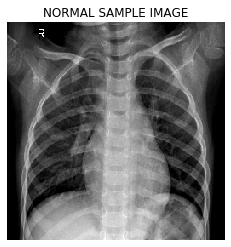

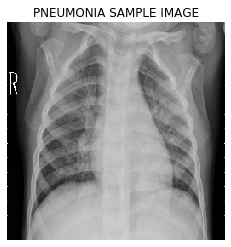

In [8]:
normal_sample = cv2.imread("chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg")
im_resized = cv2.resize(normal_sample, (256, 256), interpolation=cv2.INTER_LINEAR)
plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title('NORMAL SAMPLE IMAGE')
plt.show()

pneumonia_sample = cv2.imread("chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg")
im_resized = cv2.resize(pneumonia_sample, (256, 256), interpolation=cv2.INTER_LINEAR)
plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title('PNEUMONIA SAMPLE IMAGE')
plt.show()

### Data Set Split
Using the initial dataset split, I was able to get test accuracy of over 89% with some of the models I deployed but the 
way the dataset was split was extremely bad statistical practice as 89% was training data with most of the remainder 
being test data. Model Evaluations really couldn’t be seen as very reliable because we’d have to base accuracy performance on 
only the (relatively small) test set. 
 
To combat this issue, I started by pooling all the Normal and Pneumonia images into single 
folders and then renaming them with random numbers. After this I did 70:15:15 train:validate:test split to give my 
results more credibility. This also made adjusting hyper-parameters easier as I now had access to a larger validation 
set during the training process. The problem I found with my corrected dataset was that my models really struggled to 
recognise any ‘Normal’ images 
 
I ended up experimenting with both splits in the interest of being thorough, but I found the initial set was much more responsive to changes in model
complexity and hyper-parameters which, for my purposes was more important. 
### Summary of the Models Used to Experiment
I used a total of 5 different models with each subsequent model more complex than the previous one.
1. 2 Convolution blocks (64 filters), 2 Dropout layers, 2 Dense layers 
2. 4 Convolution blocks (64 filters), 2 Dropout layers, 2 Dense layers
3. 4 Convolution blocks (ascending filter size), 2 Dropout layers, 2 Dense layers
4. 6 Convolution blocks (ascending filter size) with  BatchNormalization, 3 Dropout layers, 2 Dense layers
5. 6 Convolution blocks (ascending filter size) with  BatchNormalization, 3 Dropout layers, 3 Dense layers
 
More detailed structure tables can be found in the Appendix at the end of the notebook for the interested reader.

### Setting Up the Convoluted Neural Network in Keras
This model is model 5 from the summary above. I chose this model structure because it had the best results with the original 
dataset split but model 4 produced similar results. 
 
Keras' sequential api lets us create a new NN by adding layers to it one at a time.

In [ ]:
model = Sequential()

1st convolutional block:
- input shape is (256, 3, 3) to allow for 256x256 rgb colour images
- 16 filters for this block to allow the model to pick up more abstract patterns

In [ ]:
model.add(Conv2D(16, (3, 3),padding = 'same',activation = 'relu', input_shape=(256, 256,3)))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

2nd convolutional block:
- 32 filters for this block to pick up more complex details than the previous block
- Introduction of BatchNormalization applies a transformation that maintains the mean activation close to 0 and the 
activation standard deviation close to 1. This allows more for a greater number of convoluted blocks in the model as 
activation values remain sufficiently scaled.

In [ ]:
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

3rd convolutional block:
- 64 filters for this block to pick up more complex details than the previous block

In [ ]:
model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

We add a Dropout layer to help reduce training bias and make neurons work harder to find patterns without memorising the 
data. The dropout layer randomly throws away some of the data by cutting some of the connections between layers (in
this case 15%) to prevent overfitting.

In [ ]:
model.add(Dropout(0.15))

4th convolutional block:
- 128 filters for this block to pick up more details than the previous block

In [ ]:
model.add(Conv2D(128, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(128, (3, 3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

5th convolutional block:
- 256 filters for this block to pick up more details than the previous block

In [ ]:
model.add(Conv2D(256, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(256, (3, 3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

We add another Dropout layer to prevent overfitting.

In [ ]:
model.add(Dropout(0.20))

6th convolutional block:
- 512 filters for this block to pick up more details than the previous block.

In [ ]:
model.add(Conv2D(512, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(512, (3, 3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

We add a flatten layer to transition between convolutional and dense layers because we need to signal to Keras that 
we're no longer working with 2D data.

In [ ]:
model.add(Flatten())

We add 2 dense (fully connected) layers to form the last set of nodes before classification.

In [ ]:
model.add(Dense(512, activation="relu"))
model.add(Dense(128, activation="relu"))

We add another Dropout layer to prevent overfitting and make the network work harder to classify items correctly.

In [ ]:
model.add(Dropout(0.20))

The last layer does the classification. It is a single node and uses softmax activation for image classification for 
this binary case.

In [ ]:
model.add(Dense(1, activation="sigmoid"))

Next, we compile our NN. This is where we tell Keras that we wanna create the NN in memory, how we'll be training it and 
how we will be measuring its accuracy.
- We use binary binary crossentropy as the loss function because we are doing a binary classification.
- We use rmsprop as an optimization function because it is a suitable adaptive learning rate algorithm.
- We only use the accuracy metric because, for the purpose of gauging my network(s), it is adequate.

In [ ]:
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop', 
  metrics=['accuracy'] 
)

The summary function provides a summary of all the layers of the model we just compiled.

In [ ]:
model.summary()

### Loading Training Data
We use keras.preprocessing's ImageDataGenerator to create iterators for our dataset.
 
The batch size=64 is number of images used in each batch for training, validation and testing. The epochs=6 is the 
number of times the the training data is passed through the model.

In [ ]:
batch_size = 64
epochs = 6

Next, we set up iterators for each dataset.
 
First we create an ImageDataGenerator object, then we create iterators using ImageDataGenerator's flow_from_directory 
function:
- Target size specifies the 256x256 image resolution we're using
- Batch size is set to to our pre-decided batch size
- Class mode is set to binary so that the generator knows we're only using two classes.
 
This will also return the size of each set in the iterators.

In [ ]:
datagen = ImageDataGenerator()
train_gen = datagen.flow_from_directory('chest_xray/train/',
                                       target_size=(256, 256),
                                       batch_size= batch_size,
                                       class_mode='binary')
val_gen = datagen.flow_from_directory('chest_xray/test/',
                                     target_size=(256, 256),
                                     batch_size= batch_size,
                                     class_mode='binary')
test_gen = datagen.flow_from_directory('chest_xray/test/',
                                       target_size=(256, 256),
                                       batch_size= batch_size,
                                       class_mode='binary', 
                                       shuffle=False)

### Training the Model
We use the fit_generator function to train the model:
- steps per epoch denotes how many 

In [7]:
model.fit_generator(
        train_gen,
        steps_per_epoch=5216 // batch_size, 
        epochs=epochs,
        validation_data=val_gen,
        validation_steps=624 // batch_size)

Epoch 1/1
81/81 [==============================] - 1031s 13s/step - loss: 82.5333 - accuracy: 0.8131 - val_loss: 0.4988 - val_accuracy: 0.8108

### Saving Model's Structure and Weights
We save the model in a json file and the weights in the binary h5 format

In [7]:
model_structure=model.to_json()
f = Path("model_structure.json")
f.write_text(model_structure)
model.save_weights('model_weights.h5') 

### Evaluating Performance

### Appendix
Every convoluted layer I implemented uses 3x3 convolution as well as a ReLU activation function.